In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
import os
import yaml
import torch
import numpy as np
import scipy
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import rbf_kernel, pairwise_distances
import matplotlib.pyplot as plt
from pprint import pprint

from eeg_otta.utils.get_accuracy import get_accuracy
from eeg_otta.models import BaseNet
from eeg_otta.utils.get_datamodule_cls import get_datamodule_cls
from eeg_otta.utils.seed import seed_everything
from eeg_otta.tta.energy_adaptation import EnergyAdaptation

In [32]:
EEG_PROJECT_PATH = "."
CHECKPOINT_PATH = os.path.join(EEG_PROJECT_PATH, "checkpoints")
CONFIG_DIR = os.path.join(EEG_PROJECT_PATH, "configs")
DEFAULT_CONFIG = "tta_energy.yaml"

In [33]:
with open(os.path.join(CONFIG_DIR, DEFAULT_CONFIG)) as f:
    config = yaml.safe_load(f)

In [34]:
config

{'source_run': 'src-bcic2a_loso_2023-12-04_14-40-57',
 'tta_method': 'energy_adaptation',
 'continual': False,
 'tta_config': {'alignment': False,
  'averaging_method': 'ema',
  'align_alpha': 0.1,
  'buffer_length': 32,
  'optimizer': 'Adam',
  'optimizer_kwargs': {'lr': 0.005, 'beta': 0.9, 'weight_decay': 0.0},
  'log_name': 'energy-pink_noise'}}

In [35]:
hyperparams = {
        'sgld_steps': 80,
        'sgld_lr': 4,
        'sgld_std': 0.01,
        'reinit_freq': 0.5,
        'adaptation_steps': 5,
    }

config['tta_config']['hyperparams'] = hyperparams

In [36]:
with open(os.path.join(CHECKPOINT_PATH, config["source_run"], "config.yaml")) as f:
    source_config = yaml.safe_load(f)
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")

seed_everything(source_config["seed"])

datamodule_cls = get_datamodule_cls(source_config["dataset_name"])
model_cls = BaseNet

Setting all random seeds to 0, cuda_available=True


In [37]:
SUBJECT_ID = 3
ckpt_path = os.path.join(CHECKPOINT_PATH, config["source_run"], str(SUBJECT_ID), "model-v1.ckpt")

model = model_cls.load_from_checkpoint(ckpt_path, map_location=device)

datamodule = datamodule_cls(source_config["preprocessing"], subject_ids=[SUBJECT_ID])
datamodule.subject_id = SUBJECT_ID
datamodule.prepare_data()
datamodule.setup()

48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events foun

/home/benjamin/.conda/envs/eeg-tea/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function scale is deprecated; will be removed in 0.8.0. Use numpy.multiply inside a lambda function instead.
  warnings.warn(msg, category=FutureWarning)


Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']

In [50]:
config['tta_config']['subject_id'] = SUBJECT_ID
config['tta_config']['mita'] = False
config['tta_config']['initialise_log'] = False
energy_model = EnergyAdaptation(model, config["tta_config"], datamodule.info)

#Trainable/total parameters: 224/3692


In [51]:
def get_accuracy2(model, data_loader):
    outputs, labels = [], []
    with torch.no_grad():
        for batch in tqdm(data_loader):
            x, y = batch
            output = torch.softmax(model(x)[1], -1)
            outputs.append(output)
            labels.append(y)

    outputs = torch.concatenate(outputs)
    labels = torch.concatenate(labels)

    y_pred = outputs.argmax(-1).cpu()
    accuracy = (y_pred == labels).float().numpy().mean()

    return accuracy

def forward(tea_model, x):
    logits, embeds = tea_model.energy_model.f(x, return_embeds=True)
    energy = -torch.logsumexp(logits, dim=-1)
    return energy, logits, embeds

def plot_pca(logits, energies, embeds, labels=None, energy_range=None, data_label=None, base_plot=None, show=True, **kwargs):
    if energy_range is None:
        lower, upper = np.quantile(energies, 0.05), np.quantile(energies, 0.95)
    else:
        lower, upper = energy_range
    sizes = (np.clip(energies, lower, upper) - lower) / (upper - lower)
    sizes = sizes * 30 + 10
    
    if base_plot is None:
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    else:
        fig, axs = base_plot
    
    if labels is None:
        axs[0].scatter(embeds[:, 0], embeds[:, 1], alpha=0.25 + 0.75 * (sizes <= 25), s=sizes, edgecolor='k')
        axs[1].scatter(logits[:, 0], logits[:, 1], alpha=0.25 + 0.75 * (sizes <= 25), s=sizes, edgecolor='k')
    else:
        for cls_label in np.unique(labels):
            idxs = labels == cls_label
            axs[0].scatter(embeds[idxs, 0], embeds[idxs, 1], label=f'Class {cls_label}', alpha=0.25 + 0.75 * (sizes[idxs] <= 20), s=sizes[idxs])
            axs[1].scatter(logits[idxs, 0], logits[idxs, 1], label=f'Class {cls_label}', alpha=0.25 + 0.75 * (sizes[idxs] <= 20), s=sizes[idxs])

    axs[0].set_xlabel('Embeds PCA 0')
    axs[0].set_ylabel('Embeds PCA 1')
    axs[0].set_title(f'Plotting {data_label or "-"} data in the embedding space')
    axs[1].set_xlabel('Logit 0')
    axs[1].set_ylabel('Logit 1')
    axs[1].set_title(f'Plotting {data_label or "-"} data in the logit space')
    plt.grid(True)
    plt.axis('equal')
    
    if show:
        plt.show()
    return fig, axs

plt.ioff()

In [114]:
def prepare_fake_data(tea_model, x, embed_pca, logit_pca):
    logits = []
    energies = []
    embeds = []
    predictions = []
    tea_model.energy_model.eval()

    with torch.no_grad():
        for sample in tqdm(x):
            energy, output, embed = forward(tea_model, sample.unsqueeze(0))
            prediction = torch.argmax(torch.softmax(output, -1), -1)
            
            predictions.append(prediction)
            logits.append(output)
            energies.append(energy)
            embeds.append(embed)

    logits = torch.cat(logits, dim=0).detach().numpy()
    energies = torch.cat(energies, dim=0).detach().numpy()
    embeds = torch.cat(embeds, dim=0).detach().numpy()
    predictions = torch.cat(predictions, dim=0).detach().numpy()
    
    pca_logits = logit_pca.transform(logits)
    pca_embeds = embed_pca.transform(embeds)
    return dict(
        logits=pca_logits,
        labels=predictions,
        energies=energies,
        embeds=pca_embeds,
        orig_logits=logits,
        orig_embeds=embeds,
    )

def prepare_labeled_data(tea_model, data_loader, embed_pca, logit_pca, fit_pca=False):
    logits = []
    energies = []
    embeds = []
    labels = []
    predictions = []
    tea_model.energy_model.eval()

    with torch.no_grad():
        for x, y in tqdm(data_loader):
            x = x.to(device)
            energy, output, embed = forward(tea_model, x)
            prediction = torch.argmax(torch.softmax(output, -1), -1)
            
            logits.append(output)
            energies.append(energy)
            embeds.append(embed)
            labels.append(y)
            predictions.append(prediction)

    logits = torch.cat(logits, dim=0).detach().cpu().numpy()
    energies = torch.cat(energies, dim=0).detach().cpu().numpy()
    embeds = torch.cat(embeds, dim=0).detach().cpu().numpy()
    labels = torch.cat(labels, dim=0).detach().cpu().numpy()
    
    return dict(
        logits=logits,
        energies=energies,
        embeds=embeds,
        labels=labels,
        predictions=predictions,
        orig_logits=logits,
        orig_embeds=embeds,
    )

## Visualizing train split

In [115]:
logit_pca = TSNE(n_components=1)
embed_pca = TSNE(n_components=2)

train_features = prepare_labeled_data(
    energy_model,
    datamodule.train_dataloader(),
    embed_pca=embed_pca,
    logit_pca=logit_pca,
    fit_pca=True,
)

energy_range = (np.quantile(train_features["energies"], 0.05), np.quantile(train_features["energies"], 0.95))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 116.36it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


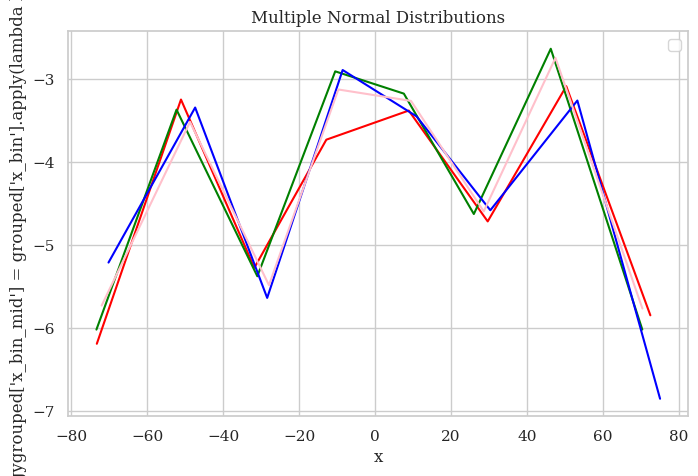

In [111]:

import pandas as pd
plt.figure(figsize=(8, 5))

colors = ['red', 'green', 'blue', 'pink']
for split in [train_features]:
    params = []
    for cls_label in np.unique(labels):
        idxs = labels == cls_label
        df = pd.DataFrame({
            'x': split['logits'][idxs].squeeze(),
            'y': split['energies'][idxs].squeeze(),  # y shifted by label
            'x_bins': pd.qcut(split['logits'][idxs].squeeze(), q=8),
        })
        # Group by 'x' and 'label', compute mean of 'y'
        grouped = df.groupby(['x_bins'])['y'].mean().reset_index()
        grouped['x_bin_mid'] = grouped['x_bins'].apply(lambda b: b.mid)
        plt.plot(grouped['x_bin_mid'], grouped['y'], color=colors[cls_label])  # no marker(    
    plt.title("Multiple Normal Distributions")
    plt.xlabel("x")
    plt.ylabel("Energygrouped['x_bin_mid'] = grouped['x_bin'].apply(lambda b: b.mid)")
    plt.legend()
    plt.grid(True)
    plt.show()
   

## Visualizing test split

In [116]:
test_features = prepare_labeled_data(
    energy_model,
    datamodule.test_dataloader(),
    embed_pca=embed_pca,
    logit_pca=logit_pca,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 130.48it/s]


In [125]:
sample_indices = np.random.choice(len(train_features['logits']), size=len(test_features['logits']), replace=False)

merged = {key: train_features[key][sample_indices] + test_features[key] for key in ['logits', 'labels', 'embeds', 'energy']}
merged['split'] = ['train'] * len(sample_indices) + ['test'] * len(test_features['logits'])

df = pd.DataFrame(
    logits = train_features['logits'][sample_indices] + test_features['logits']
    labels = train_features['labels'][sample_indices] + test_features['labels']
    
)

In [108]:
plot_pca(**test_features, energy_range=energy_range, data_label="test")

NameError: name 'test_features' is not defined

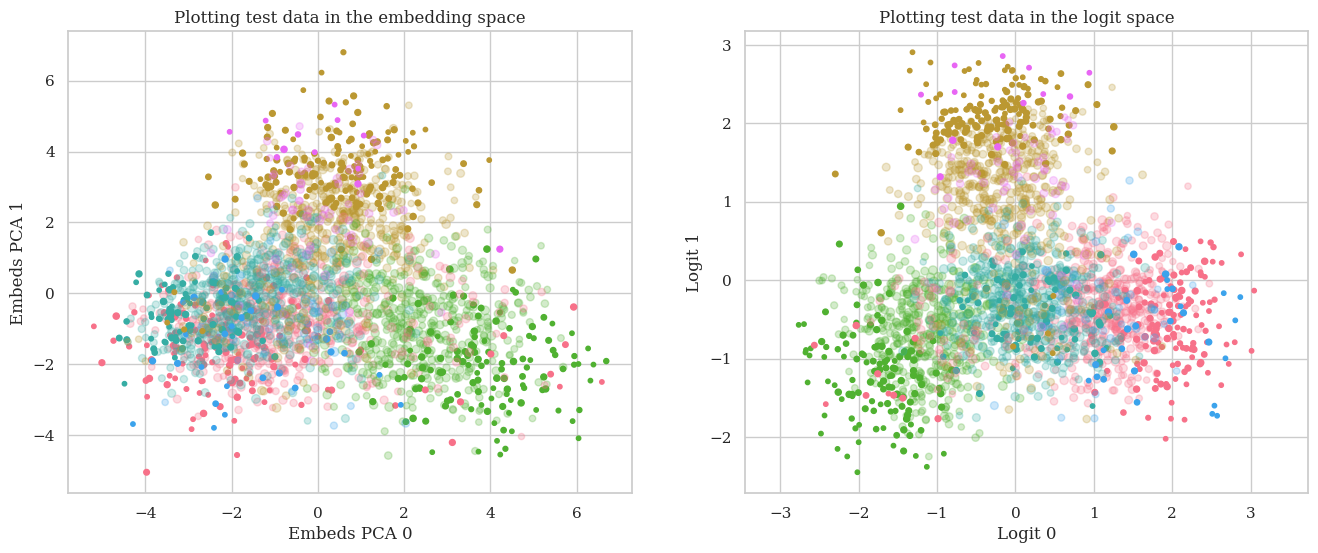

(<Figure size 1600x600 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Plotting test data in the embedding space'}, xlabel='Embeds PCA 0', ylabel='Embeds PCA 1'>,
        <AxesSubplot: title={'center': 'Plotting test data in the logit space'}, xlabel='Logit 0', ylabel='Logit 1'>],
       dtype=object))

In [16]:
train_plot = plot_pca(**train_features, energy_range=energy_range, data_label="train", show=False)
plot_pca(**test_features, energy_range=energy_range, data_label="test", base_plot=train_plot)

In [17]:
energy_model.energy_model.eval()
acc = get_accuracy2(energy_model.energy_model, datamodule.test_dataloader())
acc

100%|██████████| 5/5 [00:01<00:00,  2.84it/s]


0.8541667

## Plotting fake samples

In [18]:
x_fake, x_init = energy_model.sample_q(
    sgld_steps=100,
    adaptation_steps=None,
    sgld_lr=1, 
    sgld_std=0.1, 
    reinit_freq=0.6,
    batch_size=100, 
    series_length=1000, 
    n_channels=22, 
    device=device, 
    y=None)

In [19]:
fake_init_features = prepare_fake_data(energy_model, x_init, embed_pca=embed_pca, logit_pca=logit_pca)

100%|██████████| 100/100 [00:01<00:00, 78.45it/s]


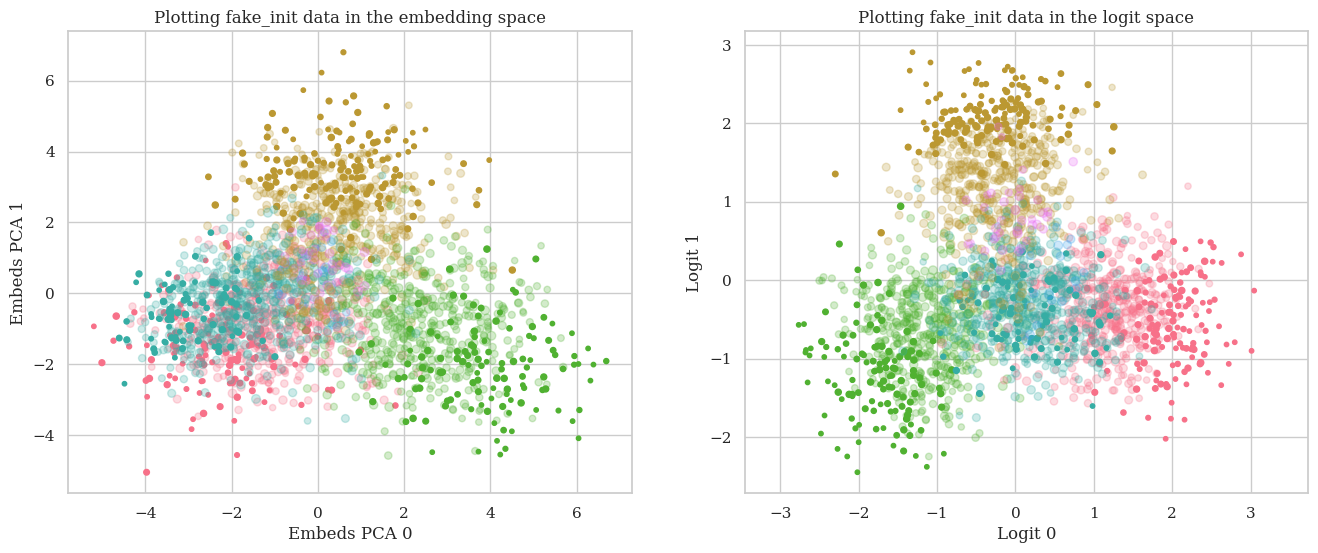

(<Figure size 1600x600 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Plotting fake_init data in the embedding space'}, xlabel='Embeds PCA 0', ylabel='Embeds PCA 1'>,
        <AxesSubplot: title={'center': 'Plotting fake_init data in the logit space'}, xlabel='Logit 0', ylabel='Logit 1'>],
       dtype=object))

In [20]:
train_plot = plot_pca(**train_features, energy_range=energy_range, data_label="train", show=False)
plot_pca(**fake_init_features, energy_range=energy_range, data_label="fake_init", base_plot=train_plot)

In [21]:
fake_data_features = prepare_fake_data(energy_model, x_fake, embed_pca=embed_pca, logit_pca=logit_pca)
#fake_data_features["labels"] = None

100%|██████████| 100/100 [00:01<00:00, 88.92it/s]


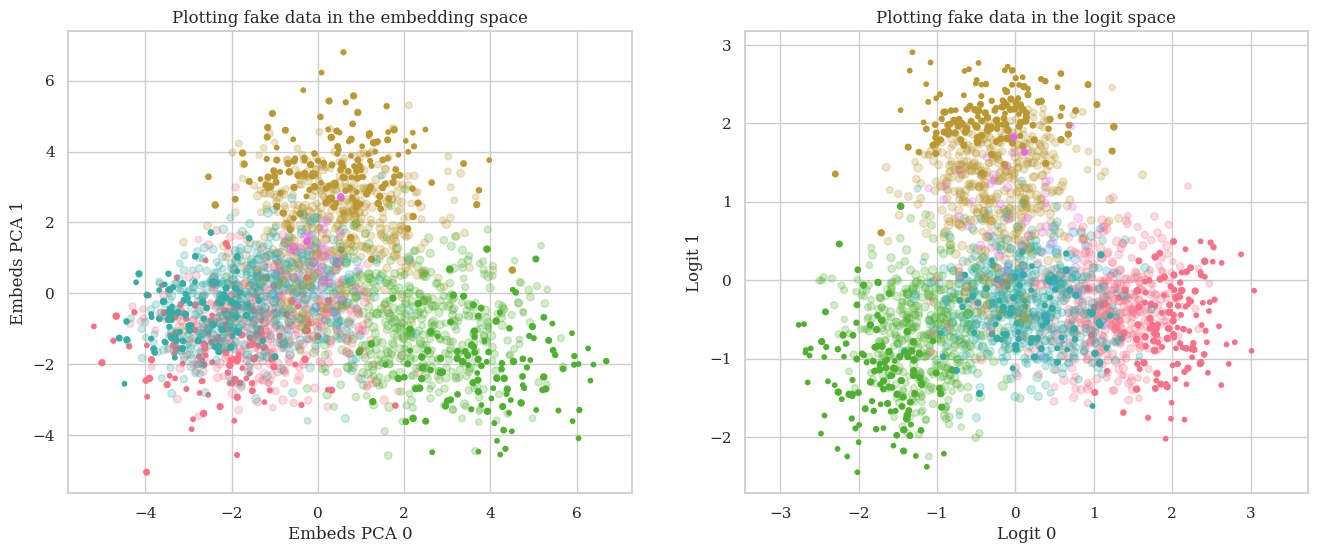

(<Figure size 1600x600 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Plotting fake data in the embedding space'}, xlabel='Embeds PCA 0', ylabel='Embeds PCA 1'>,
        <AxesSubplot: title={'center': 'Plotting fake data in the logit space'}, xlabel='Logit 0', ylabel='Logit 1'>],
       dtype=object))

In [22]:
train_plot = plot_pca(**train_features, energy_range=energy_range, data_label="train", show=False)
plot_pca(**fake_data_features, energy_range=energy_range, data_label="fake", base_plot=train_plot)

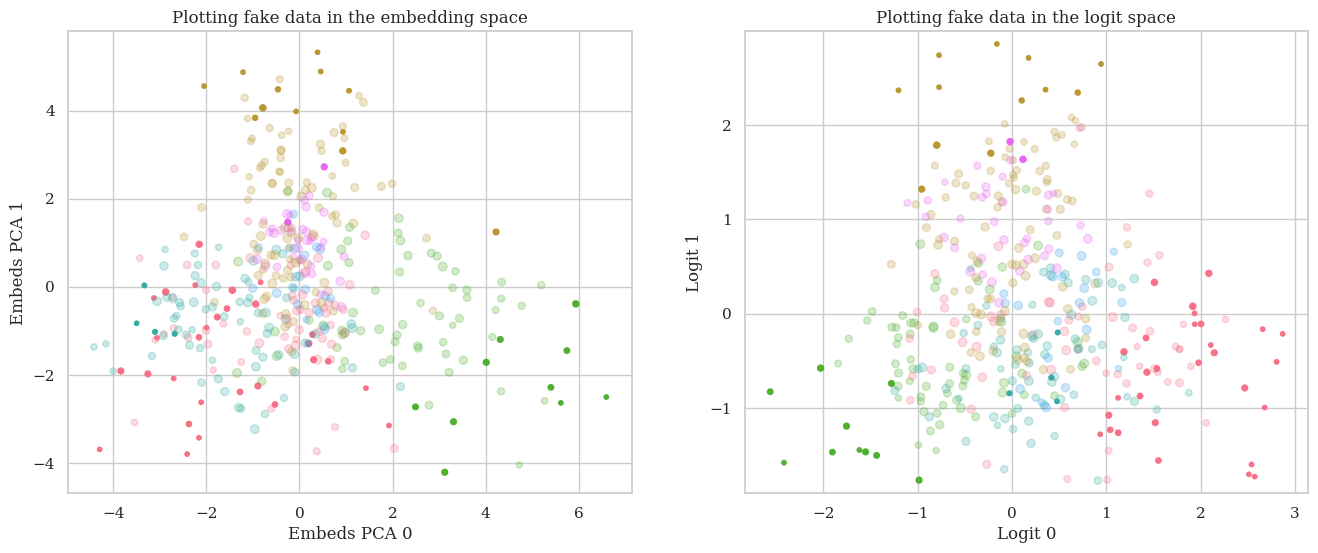

(<Figure size 1600x600 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Plotting fake data in the embedding space'}, xlabel='Embeds PCA 0', ylabel='Embeds PCA 1'>,
        <AxesSubplot: title={'center': 'Plotting fake data in the logit space'}, xlabel='Logit 0', ylabel='Logit 1'>],
       dtype=object))

In [23]:
test_plot = plot_pca(**test_features, energy_range=energy_range, data_label="test", show=False)
plot_pca(**fake_data_features, energy_range=energy_range, data_label="fake", base_plot=test_plot)

## One round of adaption

In [25]:
for i in range(10):
    for sample in tqdm(datamodule.test_dataloader()):
        x, y = sample
        e = energy_model(x, y)
        
    energy_model.energy_model.eval()
    acc = get_accuracy2(energy_model.energy_model, datamodule.test_dataloader())
    print(acc)
    i
    datamodule.train_dataloader() =
    energy_model.energy_model.train()

100%|██████████| 5/5 [00:01<00:00,  3.88it/s]


0.35416666


 20%|██        | 1/5 [10:07:04<40:28:16, 36424.18s/it]


KeyboardInterrupt: 

In [25]:
test_features_adapted = prepare_labeled_data(energy_model, datamodule.test_dataloader(), embed_pca=embed_pca, logit_pca=logit_pca)

100%|██████████| 5/5 [00:01<00:00,  4.11it/s]


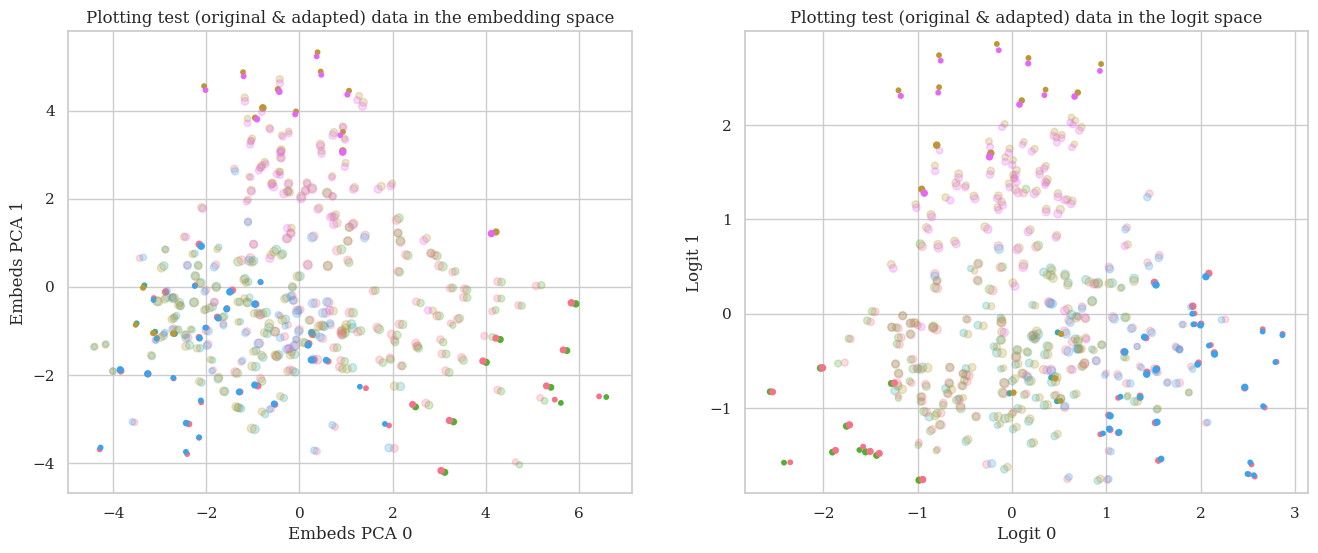

(<Figure size 1600x600 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Plotting test (original & adapted) data in the embedding space'}, xlabel='Embeds PCA 0', ylabel='Embeds PCA 1'>,
        <AxesSubplot: title={'center': 'Plotting test (original & adapted) data in the logit space'}, xlabel='Logit 0', ylabel='Logit 1'>],
       dtype=object))

In [27]:
test_plot = plot_pca(**test_features, energy_range=energy_range, data_label="test", show=False)
plot_pca(**test_features_adapted, energy_range=energy_range, data_label="test (original & adapted)", base_plot=test_plot)

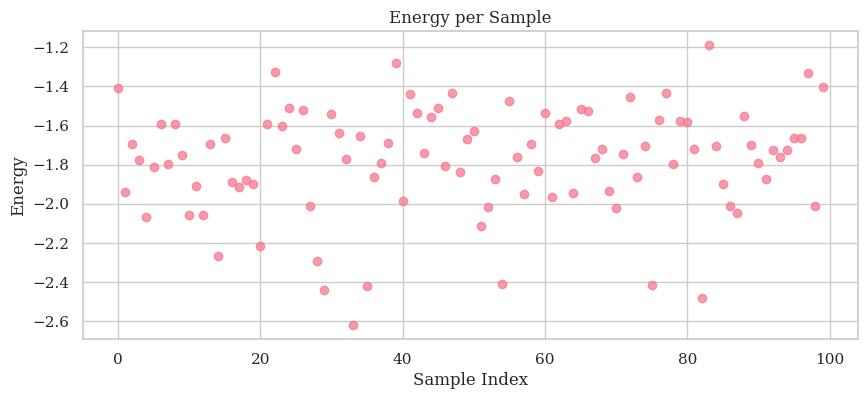

In [69]:
plt.figure(figsize=(10, 4))
plt.scatter(range(len(fake_data_features["energies"])), fake_data_features["energies"], alpha=0.7)
plt.title('Energy per Sample')
plt.xlabel('Sample Index')
plt.ylabel('Energy')
plt.grid(True)
plt.show()

In [42]:
energy_model.energy_model.eval()
acc = get_accuracy2(energy_model.energy_model, datamodule.test_dataloader())
acc

100%|██████████| 5/5 [00:01<00:00,  4.44it/s]


0.8576389

# Distribution Shift

In [80]:
def median_heuristic(x, y):
    data = np.vstack([x, y])
    dists = pairwise_distances(data, metric='euclidean')
    # Take the median of the upper triangle (excluding diagonal)
    median_dist = np.median(dists[np.triu_indices_from(dists, k=1)])
    gamma = 1 / (2 * median_dist ** 2)
    return gamma

def compute_mmd(x, y, gamma=None):
    if gamma is None:
        gamma = median_heuristic(x, y)
    K_xx = rbf_kernel(x, x, gamma=gamma)
    K_yy = rbf_kernel(y, y, gamma=gamma)
    K_xy = rbf_kernel(x, y, gamma=gamma)
    mmd = K_xx.mean() + K_yy.mean() - 2 * K_xy.mean()
    return mmd

def compute_frechet_distance(x, y):
    mu_diff = np.mean(x, axis=0) - np.mean(y, axis=0)
    cov_x, cov_y = np.cov(x, rowvar=False), np.cov(y, rowvar=False)
    covmean = scipy.linalg.sqrtm(cov_x @ cov_y)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return mu_diff @ mu_diff + np.trace(cov_x + cov_y - 2 * covmean)

def compute_distances(distance_metric, x, y, x_labels=None, y_labels=None):
    dist = distance_metric(x, y)
    if x_labels is None or y_labels is None:
        return dist
    
    results = {"overall": dist}
    cls_dist = []
    for cls_label in set(np.unique(x_labels)) & set(np.unique(y_labels)):
        dist = distance_metric(x[x_labels == cls_label], y[y_labels == cls_label])
        cls_dist.append(dist)
        results[f"cls_{cls_label}"] = dist
    
    results["cls_mean"] = np.mean(cls_dist)
    return results


In [81]:
def eval_shift(metric, x_features, y_features):
    x_embeds = x_features["orig_embeds"]
    x_labels = x_features["labels"]
    y_embeds = y_features["orig_embeds"]
    y_labels = y_features["labels"]
    
    metrics = {
        "mmd": compute_mmd,
        "frechet": compute_frechet_distance,        
    }

    try:
        results = compute_distances(metrics[metric], x_embeds, y_embeds, x_labels, y_labels)
    except KeyError:
        raise NotImplementedError(f"Distance metric '{metric}' is not available")
    
    print(f"{metric} results:")
    pprint(results)
    return results

**Maximum Mean Discrepancy**

In [87]:
# print("Train - Test (pre-adapatation)")
# eval_shift("frechet", train_features, test_features)

print("Train - Test (post-adaptation)")
eval_shift("frechet", train_features, fake_data_features)

# print("Test (pre- vs. post-adaptation)")
# eval_shift("frechet", test_features, test_features_adapted)

Train - Test (post-adaptation)
frechet results:
{'cls_0': 29.516032307393516,
 'cls_1': 22.25421459244752,
 'cls_2': 36.86272107872112,
 'cls_3': 19.151930074926053,
 'cls_mean': 26.946224513372055,
 'overall': 13.989864026755589}


{'overall': 13.989864026755589,
 'cls_0': 29.516032307393516,
 'cls_1': 22.25421459244752,
 'cls_2': 36.86272107872112,
 'cls_3': 19.151930074926053,
 'cls_mean': 26.946224513372055}

**Fréchet Distance**

In [64]:
print("Train - Test (pre-adapatation)")
eval_shift("frechet", train_features, test_features)

print("Train - Test (post-adaptation)")
eval_shift("frechet", train_features, test_features_adapted)

print("Test (pre- vs. post-adaptation)")
eval_shift("frechet", test_features, test_features_adapted)

Train - Test (pre-adapatation)
frechet results:
{'cls_0': 6.359963975150784,
 'cls_1': 6.8845559915572725,
 'cls_2': 7.552275477108918,
 'cls_3': 6.1294629162138285,
 'cls_mean': 6.731564590007701,
 'overall': 2.08687493193258}
Train - Test (post-adaptation)


NameError: name 'test_features_adapted' is not defined